https://www.youtube.com/watch?v=aHCDrAbH_go&ab_channel=LangChain

에이전트와 워크플로우 설명

### Common Patterns

- https://www.anthropic.com/research/building-effective-agents
1. **Workflow**:
    1. LLM 호출 주변에 미리 정의된 코드 경로의 스캐폴딩을 생성합니다.
    2. LLM은 미리 정의된 코드 경로를 통해 제어 흐름을 지시합니다.
2. **Agent**: 이 스캐폴딩을 제거합니다 (LLM은 자체 **actions**을 지시하고, **feedback**에 응답합니다).

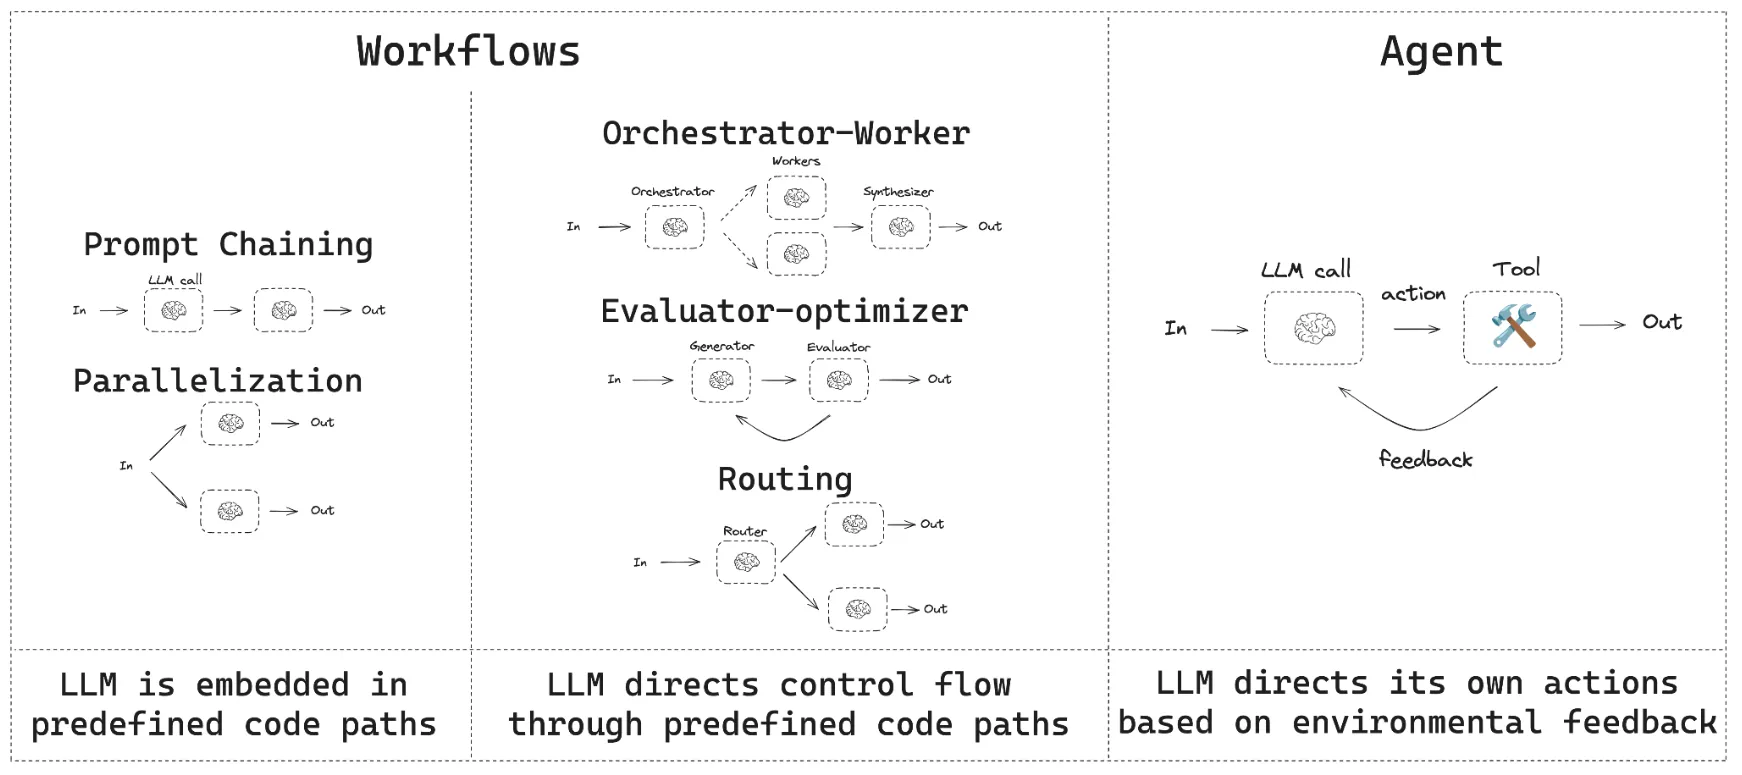



### 왜 프레임워크인가?

- 이러한 패턴을 구현하는 데 LangGraph와 같은 프레임워크가 *필수적인 것은 아닙니다*.
- LangGraph는 이러한 패턴을 구현하는 데 드는 오버헤드를 *최소화*하는 것을 목표로 합니다.
- LangGraph는 *모든* 워크플로우/에이전트의 기반이 되는 지원 인프라를 제공합니다.
    - **지속성(Persistence)**
        - 메모리
        - Human-In-The-Loop
    - **스트리밍(Streaming)**
        - 워크플로우/에이전트의 모든 LLM 호출 또는 단계에서
    - **배포(Deployment)**
        - 테스트, 디버깅 및 배포



### Augmented LLM

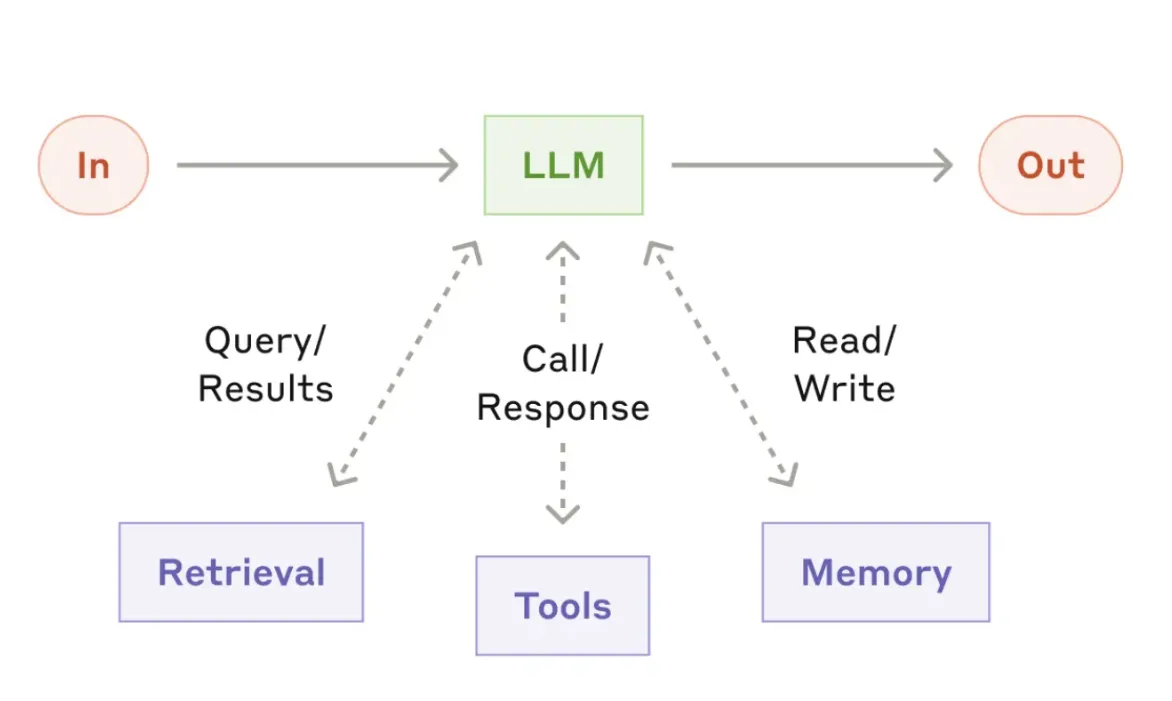

In [ ]:
!pip install langgraph

In [ ]:
pip install langchain-google-vertexai

In [1]:
# LLM
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model="gemini-2.0-flash-001")


In [6]:
# # LLM
# from langchain_anthropic import ChatAnthropic
# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


In [7]:
# Schema for structured output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Key 'justification' is not supported in schema, ignoring
Key 'justification' is not supported in schema, ignoring


Calcium CT score and high cholesterol relationship
None


In [8]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': '05257e57-c4de-40db-83d0-15af9417e573',
  'type': 'tool_call'}]



### Prompt Chaining

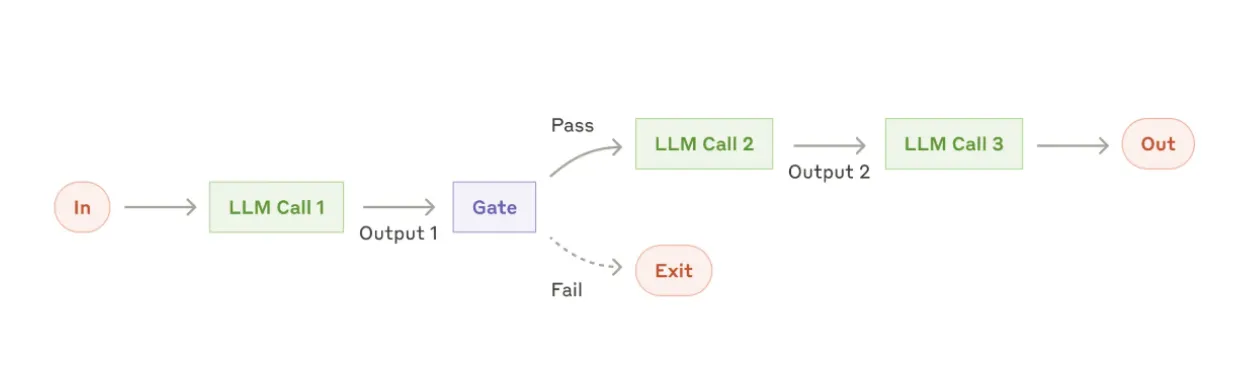

각 LLM 호출은 이전 호출의 출력을 처리합니다:
- 예: 작업을 여러 LLM 호출로 분해하는 것이 이점이 있을 때 사용합니다.

예시:
- 주제를 정하고, LLM이 농담을 만들고, 농담을 확인한 후 두 번 개선합니다

In [9]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [10]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

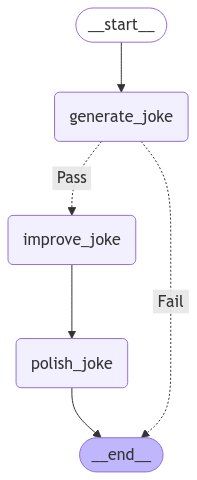

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [12]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the cat join the Red Cross? 

Because he wanted to be a first-aid kit! 


--- --- ---

Improved joke:
Okay, here are a few versions with added wordplay, aiming for different types of humor:

**Option 1 (Pun-tastic):**

Why did the cat join the Red Cross?

Because he wanted to be a **purr-amedic** and lend a **paw** in first aid!

**Option 2 (Slightly Absurdist):**

Why did the cat join the Red Cross?

Because he wanted to be a first-aid kit...or at least a **cata-lyst** for healing! He figured he could offer **paw-sitive** reinforcement.

**Option 3 (Playing on Cat Stereotypes):**

Why did the cat join the Red Cross?

Because he heard they were giving out **cat-nip** to the patients, and he wanted to be a first-aid kit so he could "accidentally" taste-test it! Besides, he's got nine lives to lend.

**Option 4 (Short and Sweet, Rhyming):**

Why did the cat join the Red Cross?

He wanted to be a first-aid pro, because caring for others is the cat's *meow*!

The best

### Parallelization

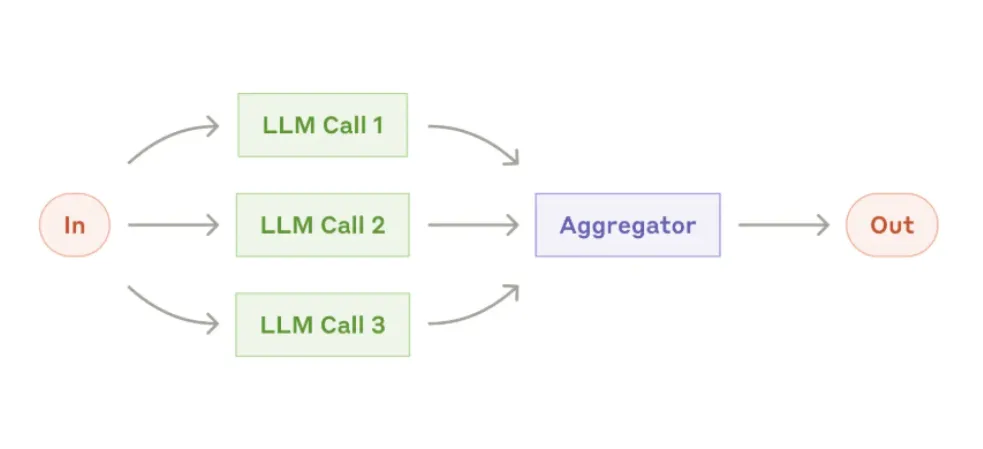

- 하위 작업들은 병렬화될 수 있습니다.
    - 예: 하나의 작업에 대해 여러 관점이 필요할 때 (RAG를 위한 다중 쿼리)
    - 예: 서로 다른 프롬프트로 독립적인 작업들을 수행할 수 있을 때

예시:

- 주제를 받아서 농담, 이야기, 시를 만들기

In [18]:
from typing import Annotated
import operator, 
from typing_extensions import TypedDict
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str
    results: Annotated[list, operator.add]


In [19]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


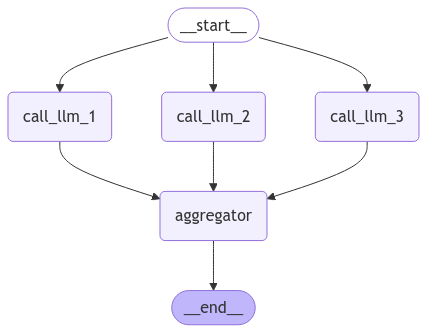

In [26]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [21]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
The alley behind Mrs. Higgins' bakery was a kingdom ruled by cats. Queen Tabitha, a sleek calico with eyes like emeralds, held court on a discarded milk crate, her tail twitching with regal impatience. Her subjects were a motley crew: Jasper, a ginger tabby with a penchant for chasing shadows; Luna, a shy, fluffy white cat who haunted the periphery, and Smokey, a grizzled tomcat with a torn ear, a veteran of countless battles.

Life in the alley was a constant negotiation between survival and comfort. Food was scarce, sourced from dropped crumbs, overflowing bins, and the occasional generous handout from Mrs. Higgins herself. Danger lurked in the form of growling dogs, speeding cars, and the unpredictable feet of humans. But the cats had each other, a silent understanding forged in shared hardship.

One day, a new contender arrived. A scrawny, jet-black kitten, no bigger than Queen Tabitha's paw, cowered behind a dumpster, his eyes wid

### Routing

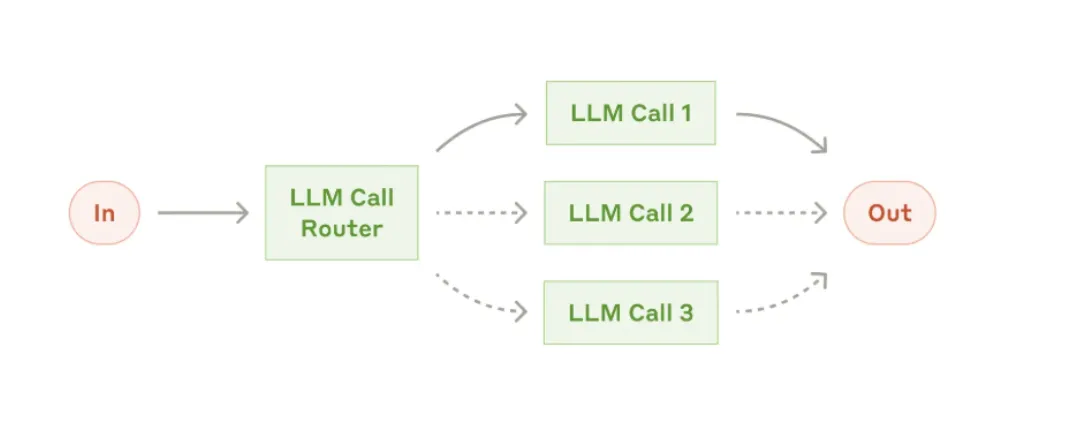

라우팅은 입력을 분류하고 전문화된 후속 작업으로 전달합니다.
- 예: 질문을 다른 검색 시스템으로 라우팅할 때
예시:
- 입력을 농담, 이야기, 시 중에서 라우팅

In [28]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [29]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [30]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

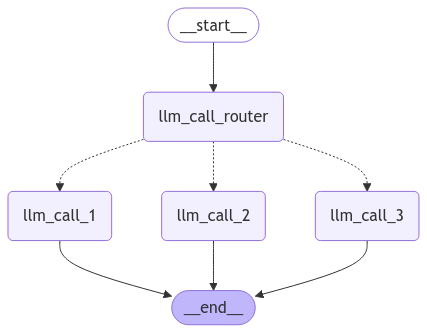

In [31]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [32]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a joke
Why did the cat join the Red Cross?

Because he wanted to be a first aid kit!



### **Orchestrator-Worker**

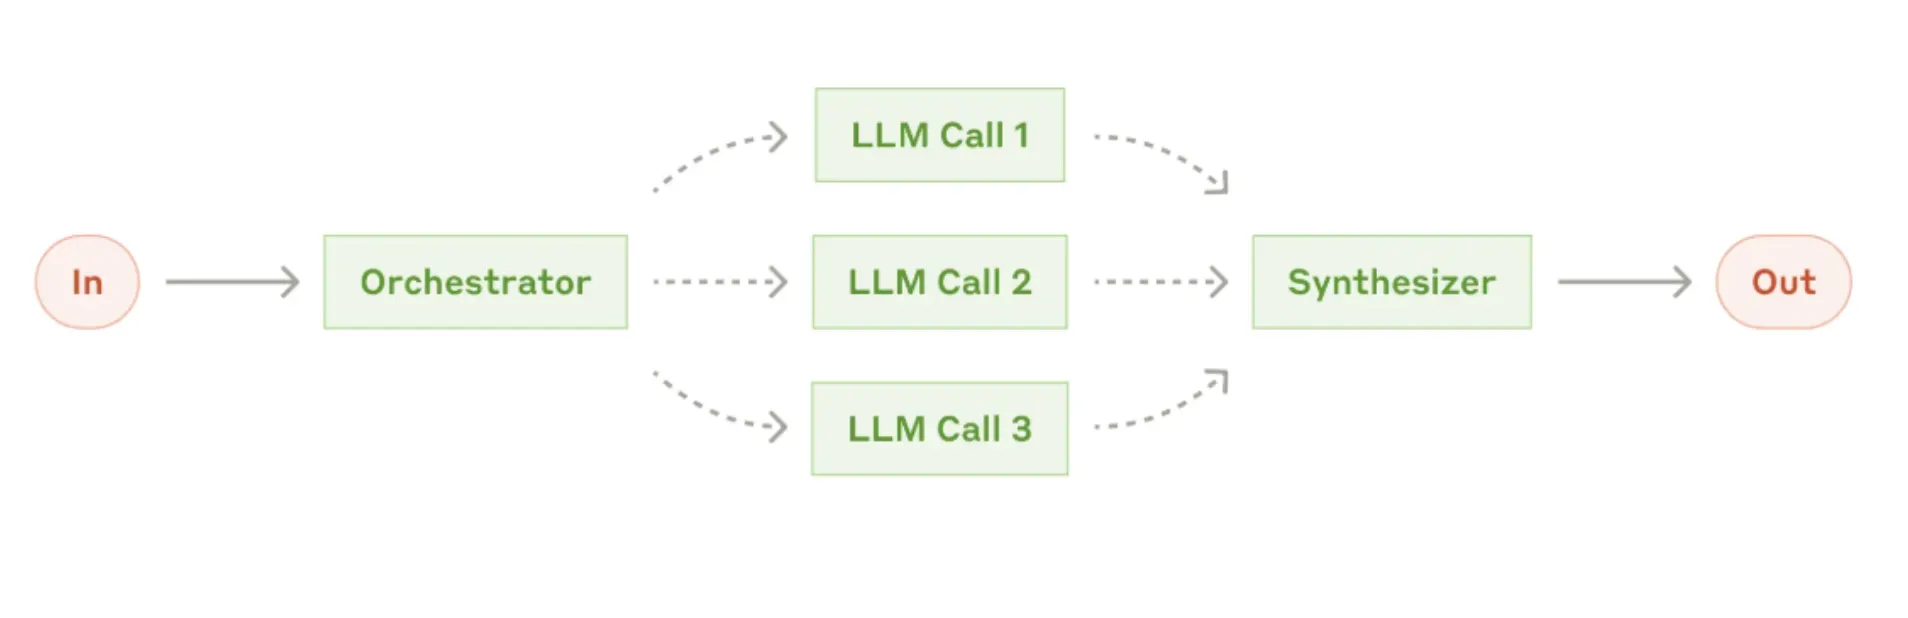

오케스트레이터는 작업을 세분화하고 각 하위 작업을 작업자에게 위임합니다.

- 예: LLM이 섹션 수를 결정할 수 있는 보고서 계획.

예시

- 주제를 정하고, 섹션별 보고서를 계획하고, 각 작업자가 섹션을 작성


In [33]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

Key '$defs' is not supported in schema, ignoring


In [34]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [53]:

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    
    # print(f"""{"*"*10}orchestrator: """)
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report in Korean."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    print(f"""{"*"*10}orchestrator: {state}""")
    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    
    # print(f"""{"*"*10}llm_call: """)
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section in Korean."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )
    print(f"""{"*"*10}llm_call: {state}""")
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """Synthesize full report from sections"""
    
    # print(f"""{"*"*10}synthesizer: """)
    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    print(f"""{"*"*10}synthesizer: {state}""")
    return {"final_report": completed_report_sections}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

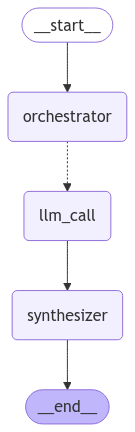

In [54]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [56]:
state = orchestrator_worker.invoke({"topic": "Create a report in Korean on 테슬라 기업에 투자르 하는 것이 좋은가? "})
from IPython.display import Markdown

Markdown(state["final_report"])

**********orchestrator: {'topic': 'Create a report in Korean on 테슬라 기업에 투자르 하는 것이 좋은가? ', 'sections': None, 'completed_sections': [], 'final_report': None}
**********llm_call: {'section': Section(name='서론', description='테슬라 기업 소개 및 현재 시장 상황 분석')}
**********llm_call: {'section': Section(name='본론 1', description='테슬라의 재무 상태 및 성장 전망 분석')}
**********llm_call: {'section': Section(name='본론 2', description='테슬라의 경쟁사 분석 및 리스크 요인 분석')}
**********llm_call: {'section': Section(name='결론', description='테슬라 투자에 대한 전반적인 평가 및 권고')}
**********synthesizer: {'topic': 'Create a report in Korean on 테슬라 기업에 투자르 하는 것이 좋은가? ', 'sections': [Section(name='서론', description='테슬라 기업 소개 및 현재 시장 상황 분석'), Section(name='본론 1', description='테슬라의 재무 상태 및 성장 전망 분석'), Section(name='본론 2', description='테슬라의 경쟁사 분석 및 리스크 요인 분석'), Section(name='결론', description='테슬라 투자에 대한 전반적인 평가 및 권고')], 'completed_sections': ['## 서론: 테슬라 기업 소개 및 현재 시장 상황 분석\n\n본 보고서는 혁신적인 기술과 과감한 경영 전략으로 전기 자동차 시장을 선도하고 있는 테슬라(Tesla, Inc.)에 대한 소개와 현재 시장 상

## 서론: 테슬라 기업 소개 및 현재 시장 상황 분석

본 보고서는 혁신적인 기술과 과감한 경영 전략으로 전기 자동차 시장을 선도하고 있는 테슬라(Tesla, Inc.)에 대한 소개와 현재 시장 상황을 분석하고자 한다. 테슬라는 단순한 자동차 제조 회사를 넘어, 에너지 저장 시스템, 태양광 발전 등 지속 가능한 에너지 솔루션 분야에서도 두각을 나타내며 미래 산업을 주도하는 기업으로 평가받고 있다.

본론에서는 테슬라의 설립 배경, 핵심 기술, 제품 라인업 및 성장 과정을 간략히 소개하고, 현재 전기 자동차 시장의 경쟁 환경, 규제 변화, 소비자 트렌드를 종합적으로 분석할 것이다. 특히, 테슬라의 시장 점유율, 경쟁사와의 차별점, 그리고 글로벌 전기 자동차 시장의 성장 잠재력에 대한 심층적인 고찰을 통해 테슬라의 현재 위치를 객관적으로 평가할 것이다.

더불어, 테슬라가 직면하고 있는 과제와 기회를 분석하여 향후 성장 전망을 제시하고, 투자자 및 관련 산업 종사자에게 유용한 정보를 제공하는 것을 목표로 한다. 본 보고서가 테슬라에 대한 이해를 높이고, 전기 자동차 시장의 미래를 예측하는데 도움이 되기를 바란다.


---

## 본론 1: 테슬라의 재무 상태 및 성장 전망 분석

본론 1에서는 테슬라의 현재 재무 상태를 심층적으로 분석하고, 이를 바탕으로 향후 성장 전망을 평가한다. 먼저, 테슬라의 최근 몇 년간의 매출, 영업이익, 순이익 등 주요 재무 지표를 살펴보고, 경쟁 기업들과 비교 분석하여 테슬라의 수익성 및 효율성을 파악한다. 특히, 테슬라의 자동차 판매량 증가 추이, 생산 능력 확대 계획, 그리고 배터리 기술 혁신 등이 재무 성과에 미치는 영향을 면밀히 분석한다.

다음으로, 테슬라의 부채 규모, 현금 보유량, 자본 구조 등 재무 건전성 지표를 분석하여 테슬라의 재무적 안정성을 평가한다. 특히, 테슬라의 대규모 투자 계획과 신규 사업 진출 등이 재무 리스크에 미치는 영향을 고려하여, 테슬라의 장기적인 지속 가능성을 전망한다.

또한, 전기차 시장의 성장 추세, 정부 정책의 변화, 그리고 경쟁 환경의 심화 등 외부 요인들이 테슬라의 성장 전망에 미치는 영향을 분석한다. 이러한 분석을 통해, 테슬라의 성장 잠재력과 투자 가치를 종합적으로 평가하고, 투자자들에게 유용한 정보를 제공하고자 한다.

마지막으로, 본 분석 결과에 기반하여 테슬라의 미래 성장 전략에 대한 시사점을 도출하고, 테슬라가 지속적인 성장을 위해 극복해야 할 과제들을 제시한다. 예를 들어, 생산 효율성 향상, 비용 절감 노력, 신규 시장 개척, 그리고 규제 변화에 대한 적응력 강화 등이 테슬라의 성공적인 성장을 위한 핵심 요소가 될 수 있을 것이다.


---

## 본론 2: 테슬라의 경쟁사 분석 및 리스크 요인 분석

본 절에서는 테슬라의 시장 경쟁 환경을 심층적으로 분석하고, 테슬라의 지속적인 성장에 잠재적인 위협 요소를 파악한다. 경쟁사 분석을 통해 테슬라의 강점과 약점을 객관적으로 평가하고, 리스크 요인 분석을 통해 향후 발생 가능한 문제점을 예측하여 테슬라의 장기적인 성장 전략 수립에 기여하고자 한다.

**2.1 경쟁사 분석**

테슬라는 전기 자동차 시장의 선두 주자로서 독보적인 위치를 차지하고 있지만, 기존 자동차 제조업체와 신규 전기 자동차 스타트업을 포함한 다양한 경쟁자들의 도전에 직면하고 있다. 주요 경쟁사로는 다음과 같은 기업들을 들 수 있다.

*   **기존 자동차 제조업체 (예: 폭스바겐 그룹, 현대자동차 그룹):** 막대한 자본력과 생산 능력을 바탕으로 전기 자동차 시장에 적극적으로 진출하고 있다. 특히, 폭스바겐 그룹은 ID. 시리즈를 통해, 현대자동차 그룹은 아이오닉 시리즈를 통해 테슬라에 대항하는 모델을 출시하며 시장 점유율을 확대하고 있다. 이들은 테슬라에 비해 광범위한 글로벌 유통망과 서비스 네트워크를 보유하고 있다는 강점을 가진다.
*   **신규 전기 자동차 스타트업 (예: 리비안, 루시드 모터스):** 혁신적인 기술과 디자인을 앞세워 프리미엄 전기 자동차 시장을 공략하고 있다. 리비안은 전기 픽업트럭과 SUV 시장에서, 루시드 모터스는 고급 세단 시장에서 테슬라와 경쟁하고 있다. 이들은 테슬라에 비해 상대적으로 짧은 개발 기간과 유연한 의사결정 구조를 통해 빠르게 시장 변화에 대응할 수 있다는 장점을 가진다.
*   **중국 전기 자동차 제조업체 (예: BYD, NIO, 샤오펑):** 중국 내수 시장을 기반으로 빠르게 성장하고 있으며, 글로벌 시장 진출을 모색하고 있다. BYD는 가격 경쟁력을 바탕으로, NIO와 샤오펑은 혁신적인 서비스와 기술을 통해 테슬라와 경쟁하고 있다. 이들은 중국 정부의 강력한 지원과 거대한 내수 시장을 기반으로 지속적인 성장을 이어갈 것으로 예상된다.

**2.2 리스크 요인 분석**

테슬라의 지속적인 성장을 위협하는 주요 리스크 요인은 다음과 같다.

*   **공급망 불안정:** 글로벌 반도체 부족, 원자재 가격 상승, 물류 차질 등의 공급망 불안정은 테슬라의 생산 능력에 부정적인 영향을 미칠 수 있다.
*   **경쟁 심화:** 경쟁사들의 공격적인 시장 진출은 테슬라의 시장 점유율 하락을 야기할 수 있다. 특히, 가격 경쟁력을 앞세운 중국 전기 자동차 제조업체들의 성장세는 테슬라에게 큰 위협이 될 수 있다.
*   **규제 강화:** 각국 정부의 환경 규제 강화와 관련된 정책 변화는 테슬라의 사업 운영에 영향을 미칠 수 있다. 예를 들어, 전기 자동차 보조금 축소, 배출가스 규제 강화 등은 테슬라의 수익성에 부정적인 영향을 미칠 수 있다.
*   **기술 혁신:** 경쟁사들의 기술 혁신은 테슬라의 기술적 우위를 약화시킬 수 있다. 특히, 배터리 기술, 자율 주행 기술 등에서 경쟁사들의 기술 발전은 테슬라의 경쟁력을 위협할 수 있다.
*   **평판 리스크:** 제품 결함, 안전 문제, 경영진의 이슈 등은 테슬라의 평판에 부정적인 영향을 미칠 수 있으며, 이는 판매 감소로 이어질 수 있다.

본 절에서 분석된 경쟁사 분석 및 리스크 요인 분석을 바탕으로, 다음 절에서는 테슬라의 경쟁 우위 확보 및 리스크 관리 전략을 제시하고자 한다.


---

## 결론 (결론)

본 보고서는 테슬라(Tesla)에 대한 투자 가능성을 전반적으로 평가하고, 투자자에게 구체적인 권고 사항을 제시하고자 합니다.

**전반적인 평가:**

테슬라는 혁신적인 기술력, 강력한 브랜드 이미지, 그리고 성장 잠재력을 기반으로 전기차 시장을 선도하는 기업입니다. 하지만 높은 변동성, 경쟁 심화, 그리고 거시 경제 상황에 대한 민감성 등 투자 리스크 또한 존재합니다.

* **강점:** 전기차 시장 점유율 확대, 에너지 사업 성장 가능성, 자율주행 기술 개발 선도, 슈퍼차저 네트워크 구축
* **약점:** 높은 주가 변동성, 경쟁 심화, 공급망 문제, 마진 압박 가능성, CEO 리스크 (일론 머스크)

**권고:**

테슬라에 대한 투자 결정은 투자자의 위험 감수 성향, 투자 목표, 그리고 투자 기간을 고려하여 신중하게 이루어져야 합니다.

* **장기 투자 관점:** 테슬라의 장기적인 성장 잠재력을 긍정적으로 평가한다면, 분할 매수 전략을 통해 투자 위험을 분산하는 것을 고려할 수 있습니다. 미래 모빌리티 시장을 선도할 가능성을 높게 평가하고 꾸준히 기업의 성장성을 지켜보며 투자하는 전략입니다.
* **단기 투자 관점:** 주가 변동성이 크므로 단기적인 시세 차익을 노리는 투자는 높은 위험을 감수해야 합니다. 기술적 분석 및 시장 상황에 대한 면밀한 검토가 필수적이며, 손절매 규칙을 명확하게 설정해야 합니다.
* **투자 포트폴리오:** 테슬라 투자는 전체 투자 포트폴리오의 일정 비율 이내로 제한하여 위험을 관리하는 것이 바람직합니다. 분산 투자를 통해 특정 종목에 대한 의존도를 낮추고, 안정적인 투자 수익을 추구하는 것이 중요합니다.

**결론적으로, 테슬라는 높은 성장 잠재력을 지닌 기업이지만, 투자 리스크 또한 상당합니다. 투자 결정을 내리기 전에 충분한 정보를 수집하고 분석하여, 자신의 투자 목표와 위험 감수 능력에 맞는 투자 전략을 수립하는 것이 중요합니다.**

(Translation:

## Conclusion

This report aims to comprehensively evaluate the investment potential of Tesla and provide specific recommendations to investors.

**Overall Assessment:**

Tesla is a leading company in the electric vehicle market, based on its innovative technology, strong brand image, and growth potential. However, there are also investment risks such as high volatility, intensifying competition, and sensitivity to macroeconomic conditions.

* **Strengths:** Expanding electric vehicle market share, growth potential in the energy business, leading the development of autonomous driving technology, building a Supercharger network
* **Weaknesses:** High stock price volatility, intensifying competition, supply chain issues, potential margin pressure, CEO risk (Elon Musk)

**Recommendation:**

Investment decisions regarding Tesla should be made carefully, considering the investor's risk tolerance, investment objectives, and investment horizon.

* **Long-Term Investment Perspective:** If you have a positive assessment of Tesla's long-term growth potential, you may consider a dollar-cost averaging strategy to diversify investment risk. This is a strategy of highly evaluating the potential to lead the future mobility market and continuously monitoring the company's growth.
* **Short-Term Investment Perspective:** Because the stock price is highly volatile, investing for short-term capital gains requires taking on high risks. A thorough review of technical analysis and market conditions is essential, and stop-loss rules must be clearly defined.
* **Investment Portfolio:** It is advisable to limit Tesla investment to a certain percentage of the overall investment portfolio to manage risk. It is important to reduce reliance on specific stocks through diversification and to pursue stable investment returns.

**In conclusion, Tesla is a company with high growth potential, but the investment risk is also significant. Before making an investment decision, it is important to gather and analyze sufficient information and establish an investment strategy that matches your investment goals and risk tolerance.**)


### **Evaluator-optimizer**

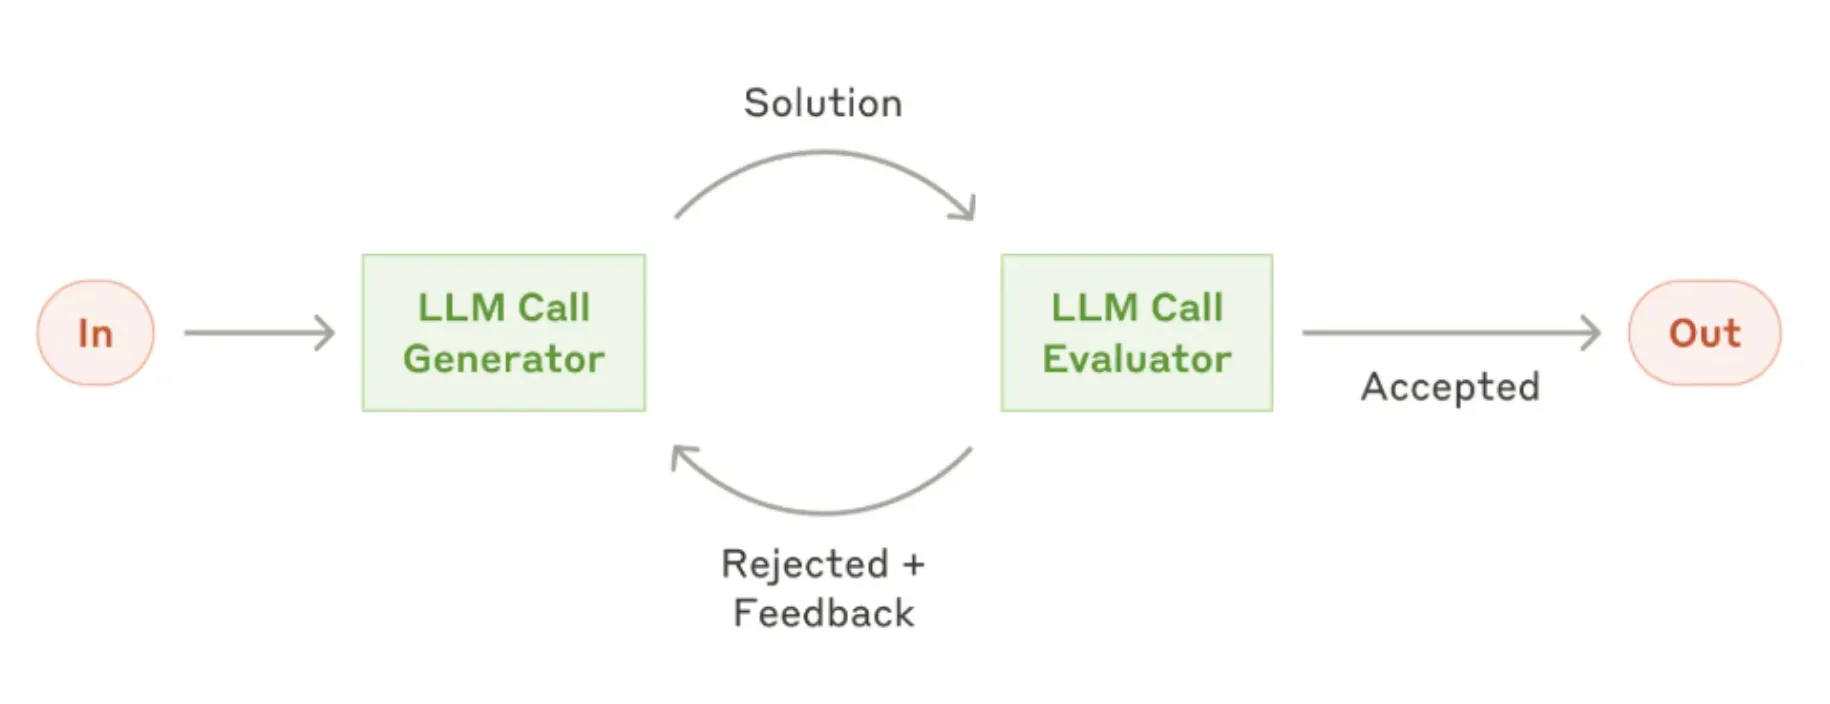

하나의 LLM 호출이 응답을 생성하는 동안 다른 하나는 루프에서 평가와 피드백을 제공합니다.

- 예: RAG 시스템의 응답 품질을 평가할 때 (환각 현상에 대해).

In [76]:
from typing_extensions import TypedDict
# from typing import TypedDict
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [77]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [78]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

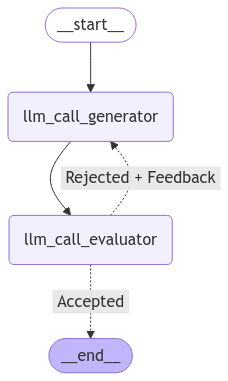

In [79]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [69]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])


Why did the cat join the Red Cross? 

Because he heard they were looking for first-aid kits! 



### Agent

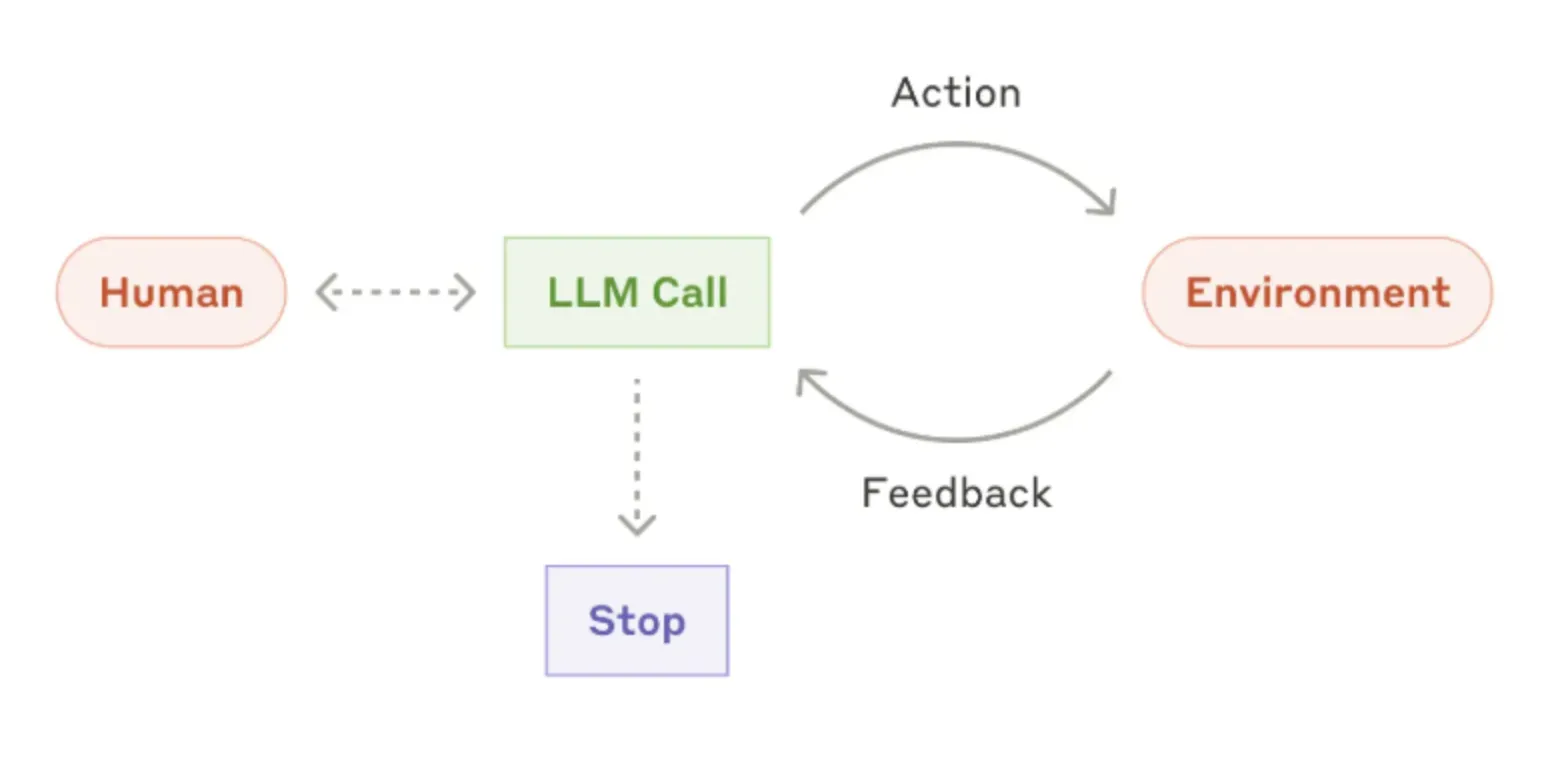

에이전트는 계획을 세우고, 행동을 취하며(도구 호출을 통해), 피드백에 응답합니다(반복적으로).

- 예: 워크플로우로 정의할 수 없는 개방형 문제를 해결할 때


In [1]:
# LLM
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model="gemini-2.0-flash-001")


In [8]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import Literal
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage


In [9]:
from typing_extensions import TypedDict
# Graph state
class State(TypedDict):
     messages: list  
    # joke: str
    # topic: str
    # feedback: str
    # funny_or_not: str

In [10]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [11]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

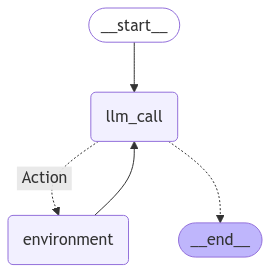

In [12]:

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================
Tool Calls:
  add (5b907b0e-1bf2-4afd-b243-06c5e269538a)
 Call ID: 5b907b0e-1bf2-4afd-b243-06c5e269538a
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (0cdcf8aa-5dd0-4618-a8b8-b8a0b0483c37)
 Call ID: 0cdcf8aa-5dd0-4618-a8b8-b8a0b0483c37
  Args:
    a: 7.0
    b: 4.0
================================= Tool Message =================================

28
================================== Ai Message ==================================

The result is 28.




```python

```